## Import Packages

In [1]:
!pip install meteocalc
from meteocalc import feels_like, Temp
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import datetime
import gc



In [3]:
pwd

'/home/arjun/kaggle'

In [4]:
import os

for dirname, _, filenames in os.walk('/home/arjun/kaggle/ashare'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/arjun/kaggle/ashare/test.csv
/home/arjun/kaggle/ashare/Fork of Fork of Fork of ASHRAE- V2 Fixed IT-2 kfol.ipynb
/home/arjun/kaggle/ashare/train.csv
/home/arjun/kaggle/ashare/sample_submission.csv
/home/arjun/kaggle/ashare/weather_test.csv
/home/arjun/kaggle/ashare/weather_train.csv
/home/arjun/kaggle/ashare/building_metadata.csv


## Load Data

In [5]:
%%time

train_df = pd.read_csv('/home/arjun/kaggle/ashare/train.csv')

# Remove outliers
train_df = train_df [ train_df['building_id'] != 1099 ]
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

building_df = pd.read_csv('/home/arjun/kaggle/ashare/building_metadata.csv')
weather_df = pd.read_csv('/home/arjun/kaggle/ashare/weather_train.csv')


CPU times: user 6.18 s, sys: 673 ms, total: 6.85 s
Wall time: 6.86 s


In [6]:
#leaky_data = pd.read_feather("../input/ashraeleak/leak.feather")

In [7]:
#leaky_data.head()

In [8]:
train_df.head()

,building_id,meter,timestamp,meter_reading
103,105,0,2016-01-01 00:00:00,23.3036
104,106,0,2016-01-01 00:00:00,0.3746
105,106,3,2016-01-01 00:00:00,0.0000
106,107,0,2016-01-01 00:00:00,175.1840
107,108,0,2016-01-01 00:00:00,91.2653


In [9]:
#combined_train_df = pd.concat([leaky_data, train_df])

In [10]:
#train_df = combined_train_df
#del combined_train_df
#gc.collect()

## Utility Functions

In [11]:
# Original code from https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling by @aitude

def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
    
    # add wind direction features
    #source: https://github.com/energeeks/ashrae-energy-prediction/blob/master/notebooks/01-au-feature-engineering-playground.ipynb
    #wind_direction = weather_df['wind_direction']
    #data_frame.drop("wind_direction")
    weather_df["wind_direction_sin"] = np.sin(2 * np.pi * weather_df['wind_direction'] / 360)
    weather_df["wind_direction_cos"] = np.cos(2 * np.pi * weather_df['wind_direction'] / 360)
    weather_df.loc[weather_df["wind_direction"].isna(), ["wind_direction_sin", "wind_direction_cos"]] = 0
    weather_df.loc[weather_df["wind_speed"] == 0, ["wind_direction_sin", "wind_direction_cos"]] = 0

    # Ashish Gupta added 
    def get_meteorological_features(data):
        def calculate_rh(df):
            df['relative_humidity'] = 100 * (np.exp((17.625 * df['dew_temperature']) / (243.04 + df['dew_temperature'])) / np.exp((17.625 * df['air_temperature'])/(243.04 + df['air_temperature'])))
        def calculate_fl(df):
            flike_final = []
            flike = []
            # calculate Feels Like temperature
            for i in range(len(df)):
                at = df['air_temperature'][i]
                rh = df['relative_humidity'][i]
                ws = df['wind_speed'][i]
                flike.append(feels_like(Temp(at, unit = 'C'), rh, ws))
            for i in range(len(flike)):
                flike_final.append(flike[i].f)
            df['feels_like'] = flike_final
            del flike_final, flike, at, rh, ws
        calculate_rh(data)
        calculate_fl(data)
        return data
    weather_df = get_meteorological_features(weather_df)
    return weather_df

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin

In [12]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df


In [13]:
def features_engineering(df):
    
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["weekend"] = df["timestamp"].dt.weekday
    df['square_feet'] =  np.log1p(df['square_feet'])
    
    #add extra features:
    #source: https://github.com/energeeks/ashrae-energy-prediction/blob/master/notebooks/01-au-feature-engineering-playground.ipynb
    timestamp = df['timestamp']
    timestamp_seconds_of_day = (timestamp.dt.hour * 60 + timestamp.dt.minute) * 60 + timestamp.dt.second
    df["time_sin"] = np.sin(2 * np.pi * timestamp_seconds_of_day / 86400)
    df["time_cos"] = np.cos(2 * np.pi * timestamp_seconds_of_day / 86400)
    df["dayofweek_sin"] = np.sin(2 * np.pi * timestamp.dt.dayofweek / 7)
    df["dayofweek_cos"] = np.cos(2 * np.pi * timestamp.dt.dayofweek / 7)
    df["dayofyear_sin"] = np.sin(2 * np.pi * timestamp.dt.dayofyear / 366)
    df["dayofyear_cos"] = np.cos(2 * np.pi * timestamp.dt.dayofyear / 366)
    
    # Remove Unused Columns
    drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed","year_built","floor_count"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Encode Categorical Data
    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [14]:
weather_df = fill_weather_dataset(weather_df)

/home/arjun/kaggle/env_kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [15]:
weather_df.isnull().sum()

site_id               0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
timestamp             0
wind_direction        0
wind_speed            0
wind_direction_sin    0
wind_direction_cos    0
relative_humidity     0
feels_like            0
dtype: int64

## Memory Reduction

In [16]:
train_df = reduce_mem_usage(train_df,use_float16=True)
building_df = reduce_mem_usage(building_df,use_float16=True)
weather_df = reduce_mem_usage(weather_df,use_float16=True)

Memory usage of dataframe is 757.31 MB
Memory usage after optimization is: 322.24 MB
Decreased by 57.4%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%
Memory usage of dataframe is 13.94 MB
Memory usage after optimization is: 3.73 MB
Decreased by 73.2%


## Merge Data

We need to add building and weather information into training dataset.

In [17]:
train_df = train_df.merge(building_df, left_on='building_id',right_on='building_id',how='left')
train_df = train_df.merge(weather_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])
del weather_df
gc.collect()

0

## Features Engineering

In [18]:
train_df = features_engineering(train_df)

In [19]:
train_df.isna().sum()

building_id           0
meter                 0
meter_reading         0
site_id               0
primary_use           0
square_feet           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
wind_direction_sin    0
wind_direction_cos    0
relative_humidity     0
feels_like            0
hour                  0
weekend               0
time_sin              0
time_cos              0
dayofweek_sin         0
dayofweek_cos         0
dayofyear_sin         0
dayofyear_cos         0
dtype: int64

## Features & Target Variables

In [20]:
def count_nan_each_column(df):
    for i in df.columns:
        #print(i)
        print( df[i].isnull().sum() )

In [21]:
count_nan_each_column(train_df)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [22]:
target = np.log1p(train_df["meter_reading"])
features = train_df.drop('meter_reading', axis = 1)
del train_df
gc.collect()

35

In [23]:
features.columns

Index(['building_id', 'meter', 'site_id', 'primary_use', 'square_feet',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'wind_direction_sin', 'wind_direction_cos',
       'relative_humidity', 'feels_like', 'hour', 'weekend', 'time_sin',
       'time_cos', 'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin',
       'dayofyear_cos'],
      dtype='object')

##  KFOLD LIGHTGBM Model

In [24]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend", "cloud_coverage"]
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1580,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    'subsample': 0.4,
    'n_jobs': -1,
    "reg_lambda": 2,
    'seed': 50,
    "metric": "rmse",        
}

kf = KFold(n_splits=10)
models = []
for train_index,test_index in kf.split(features):
    train_features = features.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = features.loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=2000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

/home/arjun/kaggle/env_kaggle/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.0146	valid_1's rmse: 1.19858
[50]	training's rmse: 0.751777	valid_1's rmse: 1.04264
[75]	training's rmse: 0.663669	valid_1's rmse: 1.01705
[100]	training's rmse: 0.61845	valid_1's rmse: 1.01453
[125]	training's rmse: 0.587558	valid_1's rmse: 1.01463
Early stopping, best iteration is:
[96]	training's rmse: 0.625382	valid_1's rmse: 1.01417
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.01354	valid_1's rmse: 1.08505
[50]	training's rmse: 0.754378	valid_1's rmse: 0.8762
[75]	training's rmse: 0.66693	valid_1's rmse: 0.819766
[100]	training's rmse: 0.619223	valid_1's rmse: 0.799351
[125]	training's rmse: 0.586212	valid_1's rmse: 0.789033
[150]	training's rmse: 0.561217	valid_1's rmse: 0.782013
[175]	training's rmse: 0.544311	valid_1's rmse: 0.777863
[200]	training's rmse: 0.530871	valid_1's rmse: 0.773631
[225]	training's rmse: 0.520271	valid_1's rmse: 0.771765
[250]	tra

Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.00856	valid_1's rmse: 1.14673
[50]	training's rmse: 0.748636	valid_1's rmse: 0.977951
[75]	training's rmse: 0.664583	valid_1's rmse: 0.943961
[100]	training's rmse: 0.618377	valid_1's rmse: 0.933018
[125]	training's rmse: 0.583948	valid_1's rmse: 0.928114
[150]	training's rmse: 0.558696	valid_1's rmse: 0.92542
[175]	training's rmse: 0.540564	valid_1's rmse: 0.924416
[200]	training's rmse: 0.52662	valid_1's rmse: 0.923317
[225]	training's rmse: 0.516811	valid_1's rmse: 0.922697
[250]	training's rmse: 0.509408	valid_1's rmse: 0.922007
[275]	training's rmse: 0.503121	valid_1's rmse: 0.92159
[300]	training's rmse: 0.497834	valid_1's rmse: 0.921662
[325]	training's rmse: 0.492818	valid_1's rmse: 0.921708
[350]	training's rmse: 0.48844	valid_1's rmse: 0.920941
[375]	training's rmse: 0.484161	valid_1's rmse: 0.920394
[400]	training's rmse: 0.480319	valid_1's rmse: 0.919907
[425]	training's rmse: 0.476386	vali

[975]	training's rmse: 0.417813	valid_1's rmse: 1.12168
[1000]	training's rmse: 0.416101	valid_1's rmse: 1.12167
[1025]	training's rmse: 0.414582	valid_1's rmse: 1.12164
[1050]	training's rmse: 0.412704	valid_1's rmse: 1.1216
[1075]	training's rmse: 0.411068	valid_1's rmse: 1.12157
[1100]	training's rmse: 0.409449	valid_1's rmse: 1.12155
[1125]	training's rmse: 0.40782	valid_1's rmse: 1.12148
[1150]	training's rmse: 0.406222	valid_1's rmse: 1.12141
[1175]	training's rmse: 0.404707	valid_1's rmse: 1.1213
[1200]	training's rmse: 0.403254	valid_1's rmse: 1.12116
[1225]	training's rmse: 0.401813	valid_1's rmse: 1.12115
[1250]	training's rmse: 0.400182	valid_1's rmse: 1.12108
[1275]	training's rmse: 0.398781	valid_1's rmse: 1.12101
[1300]	training's rmse: 0.397576	valid_1's rmse: 1.12091
[1325]	training's rmse: 0.396101	valid_1's rmse: 1.12086
[1350]	training's rmse: 0.394898	valid_1's rmse: 1.12087
[1375]	training's rmse: 0.393705	valid_1's rmse: 1.12076
[1400]	training's rmse: 0.392517	va

In [25]:
#del features, target
#gc.collect()

## Important Features

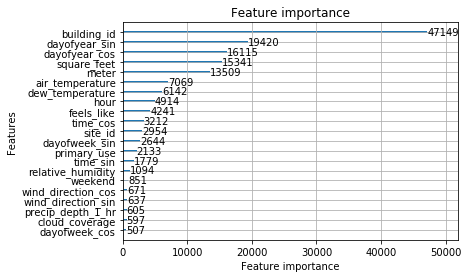

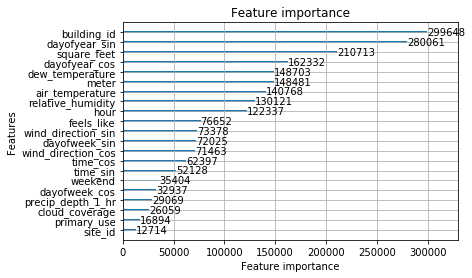

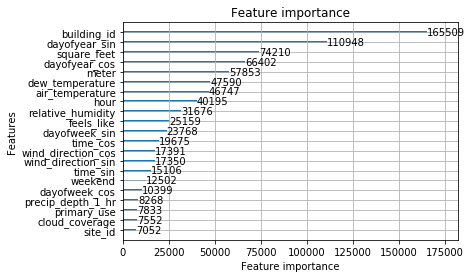

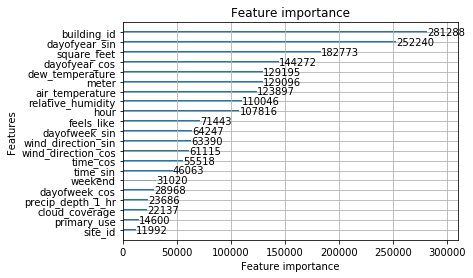

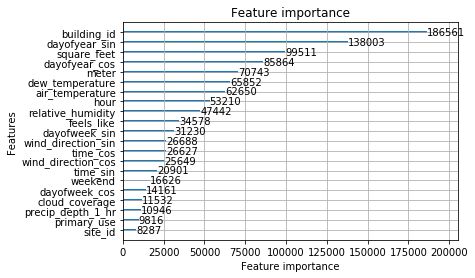

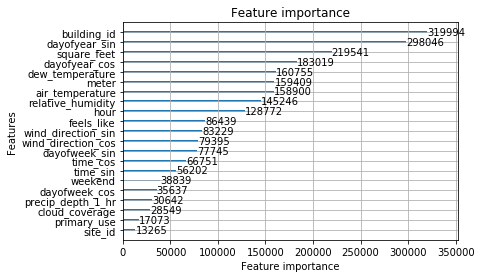

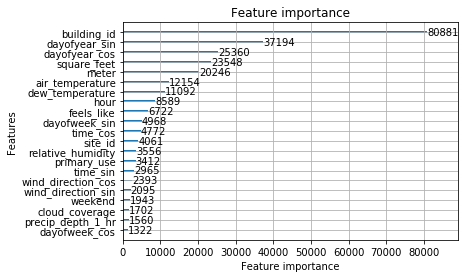

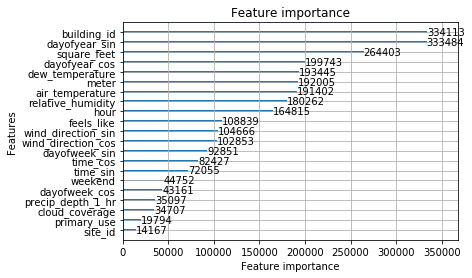

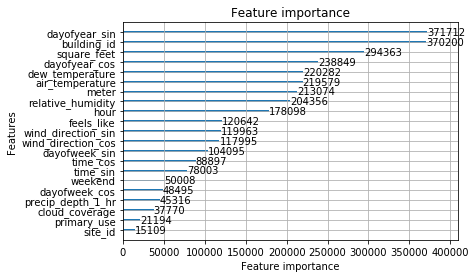

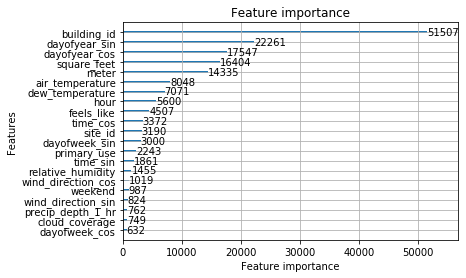

In [26]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

## Load Test Data

In [27]:
test_df = pd.read_csv('/home/arjun/kaggle/ashare/test.csv')
row_ids = test_df["row_id"]
test_df.drop("row_id", axis=1, inplace=True)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 954.38 MB
Memory usage after optimization is: 199.59 MB
Decreased by 79.1%


## Merge Building Data

In [28]:
test_df = test_df.merge(building_df,left_on='building_id',right_on='building_id',how='left')
del building_df
gc.collect()

57711

## Fill Weather Information

In [29]:
weather_df = pd.read_csv('/home/arjun/kaggle/ashare/weather_test.csv')
weather_df = fill_weather_dataset(weather_df)
weather_df = reduce_mem_usage(weather_df)


/home/arjun/kaggle/env_kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Memory usage of dataframe is 27.80 MB
Memory usage after optimization is: 13.32 MB
Decreased by 52.1%


## Merge Weather Data

In [30]:
test_df = test_df.merge(weather_df,how='left',on=['timestamp','site_id'])
del weather_df
gc.collect()

0

## Features Engineering

In [31]:
test_df = features_engineering(test_df)

In [32]:
test_df.head(20)

,building_id,meter,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,wind_direction_sin,...,relative_humidity,feels_like,hour,weekend,time_sin,time_cos,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos
0,0,0,0,0,8.913685,17.799999,4.0,11.7,0.282609,0.984808,...,67.486206,64.040001,0,6,0.0,1.0,-0.781831,0.62349,0.017166,0.999853
1,1,0,0,0,7.908755,17.799999,4.0,11.7,0.282609,0.984808,...,67.486206,64.040001,0,6,0.0,1.0,-0.781831,0.62349,0.017166,0.999853
2,2,0,0,0,8.589886,17.799999,4.0,11.7,0.282609,0.984808,...,67.486206,64.040001,0,6,0.0,1.0,-0.781831,0.62349,0.017166,0.999853
3,3,0,0,0,10.072639,17.799999,4.0,11.7,0.282609,0.984808,...,67.486206,64.040001,0,6,0.0,1.0,-0.781831,0.62349,0.017166,0.999853
4,4,0,0,0,11.666573,17.799999,4.0,11.7,0.282609,0.984808,...,67.486206,64.040001,0,6,0.0,1.0,-0.781831,0.62349,0.017166,0.999853
5,5,0,0,0,8.987322,17.799999,4.0,11.7,0.282609,0.984808,...,67.486206,64.040001,0,6,0.0,1.0,-0.781831,0.62349,0.017166,0.999853
6,6,0,0,4,10.237349,17.799999,4.0,11.7,0.282609,0.984808,...,67.486206,64.040001,0,6,0.0,1.0,-0.781831,0.62349,0.017166,0.999853
7,7,0,0,0,11.704165,17.799999,4.0,11.7,0.282609,0.984808,...,67.486206,64.040001,0,6,0.0,1.0,-0.781831,0.62349,0.017166,0.999853
8,7,1,0,0,11.704165,17.799999,4.0,11.7,0.282609,0.984808,...,67.486206,64.040001,0,6,0.0,1.0,-0.781831,0.62349,0.017166,0.999853
9,8,0,0,0,11.015510,17.799999,4.0,11.7,0.282609,0.984808,...,67.486206,64.040001,0,6,0.0,1.0,-0.781831,0.62349,0.017166,0.999853


## Prediction

In [33]:
features

,building_id,meter,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,wind_direction_sin,...,relative_humidity,feels_like,hour,weekend,time_sin,time_cos,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos
0,105,0,1,0,10.832181,3.800781,0.0,2.400391,0.0,-0.866211,...,90.5625,36.9375,0,4,0.000000,1.000000,-0.433884,-0.900969,1.716633e-02,0.999853
1,106,0,1,0,8.589514,3.800781,0.0,2.400391,0.0,-0.866211,...,90.5625,36.9375,0,4,0.000000,1.000000,-0.433884,-0.900969,1.716633e-02,0.999853
2,106,3,1,0,8.589514,3.800781,0.0,2.400391,0.0,-0.866211,...,90.5625,36.9375,0,4,0.000000,1.000000,-0.433884,-0.900969,1.716633e-02,0.999853
3,107,0,1,0,11.487946,3.800781,0.0,2.400391,0.0,-0.866211,...,90.5625,36.9375,0,4,0.000000,1.000000,-0.433884,-0.900969,1.716633e-02,0.999853
4,108,0,1,0,11.309352,3.800781,0.0,2.400391,0.0,-0.866211,...,90.5625,36.9375,0,4,0.000000,1.000000,-0.433884,-0.900969,1.716633e-02,0.999853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19852417,1444,0,15,1,9.884305,1.700195,2.0,-5.601562,-1.0,0.000000,...,58.3750,28.1250,23,5,-0.258819,0.965926,-0.974928,-0.222521,-2.449294e-16,1.000000
19852418,1445,0,15,0,8.366138,1.700195,2.0,-5.601562,-1.0,0.000000,...,58.3750,28.1250,23,5,-0.258819,0.965926,-0.974928,-0.222521,-2.449294e-16,1.000000
19852419,1446,0,15,1,9.329545,1.700195,2.0,-5.601562,-1.0,0.000000,...,58.3750,28.1250,23,5,-0.258819,0.965926,-0.974928,-0.222521,-2.449294e-16,1.000000
19852420,1447,0,15,4,10.301458,1.700195,2.0,-5.601562,-1.0,0.000000,...,58.3750,28.1250,23,5,-0.258819,0.965926,-0.974928,-0.222521,-2.449294e-16,1.000000


In [34]:
from tqdm import tqdm

In [35]:
iterations = 300
set_size = len(test_df)
batch_size = set_size // iterations
meter_reading = []
for i in tqdm(range(iterations)):
    pos = i*batch_size
    fold_preds = [np.expm1(model.predict(test_df[features.columns].iloc[pos : pos+batch_size])) for model in models]
    meter_reading.extend(np.mean(fold_preds, axis=0))
print(len(meter_reading))
assert len(meter_reading) == set_size

100%|██████████| 300/300 [3:45:14<00:00, 45.05s/it]  

41697600


In [36]:
len(test_df)

41697600

In [37]:
results_df = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(meter_reading, 0, a_max=None)})
del row_ids, meter_reading
gc.collect()
results_df.to_csv("submission.csv", index=False)


In [38]:
del test_df, models
gc.collect()

0

In [39]:
## Submission

In [40]:
results_df.head(20)

,row_id,meter_reading
0,0,92.728751
1,1,48.887884
2,2,5.273307
3,3,149.804407
4,4,769.466563
5,5,7.082391
6,6,95.876315
7,7,439.225343
8,8,505.398164
9,9,282.922071


In [41]:
results_df.shape

(41697600, 2)

In [ ]:
41697600